## PROJETO SEMANTIX ACADEMY - BIG DATA SCIENCE

- *ALUNO: RAFAEL HENRIQUE MARTELLO*
- *LinkedIn: https://www.linkedin.com/in/rhmartello/*
- *Github: https://github.com/rhmartello*

### Bibliotecas:

In [1]:
# Carregamos as bibliotecas que serão utilizadas para manipulação e visualização dos dados
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pingouin as pg
import seaborn as sns
from imblearn.pipeline import make_pipeline
import funcoes.treino_custom as treino_custom
import funcoes.feature_selection as feature_selection
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.combine import SMOTETomek
from sklearn.model_selection import train_test_split, cross_val_score
import optuna

c:\ProgramData\Anaconda3\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
c:\ProgramData\Anaconda3\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.1, the latest is 0.5.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


### Carregando Dados:

In [2]:
arquivo ='data/DADOS/MICRODADOS_ENEM_2021.csv'

df = pd.read_csv(
        arquivo,
        encoding = 'latin1',
        sep = ';'
    )

In [3]:
def pipeline_Enem(arquivo):
    # Colunas a serem lidas no arquivo
    features = ['TP_FAIXA_ETARIA',
                'TP_SEXO',
                'TP_COR_RACA',
                'TP_ESTADO_CIVIL',
                'TP_NACIONALIDADE',
                'SG_UF_PROVA',
                'TP_ESCOLA',
                'TP_LOCALIZACAO_ESC',
                'NU_NOTA_CN', 
                'NU_NOTA_CH', 
                'NU_NOTA_LC', 
                'NU_NOTA_MT',
                'NU_NOTA_REDACAO',
                'Q001', 
                'Q002', 
                'Q006', 
                'Q007'
                ]
    
    # Lemos o arquivo, retirando os registros em que um dos valores não estivesse presente.
    df = pd.read_csv(
        arquivo,
        #nrows = 5000, # 5k linhas para desenvolvimento inicial
        encoding = 'latin1',
        usecols = features,
        sep = ';'
    ).dropna()
    
    df['NOTA_MEDIA'] = (df['NU_NOTA_CN'] + df['NU_NOTA_CH'] + df['NU_NOTA_LC'] + df['NU_NOTA_MT']) / 4
    
    # Filtramos os registros de com alunos de escolas públicas e privadas (valores 2 e 3 no 
    # campo TP_ESCOLA)
    df = df.loc[df['TP_ESCOLA'].isin([2, 3])]
    df.loc[df['TP_ESCOLA']==2, 'TP_ESCOLA'] = 'Pública'
    df.loc[df['TP_ESCOLA']==3, 'TP_ESCOLA'] = 'Privada'
    
    return df

# Carregamos o dataset a partir da cópia do Kaggle
df = pipeline_Enem('data/DADOS/MICRODADOS_ENEM_2021.csv')


In [4]:
df.head()

,TP_FAIXA_ETARIA,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,TP_NACIONALIDADE,TP_ESCOLA,TP_LOCALIZACAO_ESC,SG_UF_PROVA,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,NU_NOTA_REDACAO,Q001,Q002,Q006,Q007,NOTA_MEDIA
3,3,M,1,3,1,Pública,1.0,CE,580.7,678.9,638.9,659.5,780.0,B,B,B,A,639.500
4,2,F,1,3,1,Pública,1.0,CE,497.7,532.4,457.6,582.6,780.0,D,E,C,A,517.575
33,3,M,1,1,1,Pública,1.0,BA,414.6,410.1,386.7,423.0,700.0,C,C,B,A,408.600
45,4,F,1,3,1,Pública,1.0,ES,476.8,608.5,534.2,570.2,640.0,H,E,C,A,547.425
51,3,M,1,3,1,Pública,1.0,ES,433.4,622.0,548.3,579.4,680.0,E,F,D,A,545.775


## Verificação estatística

### Comparativo estatístico de escolas públicas e privadas:

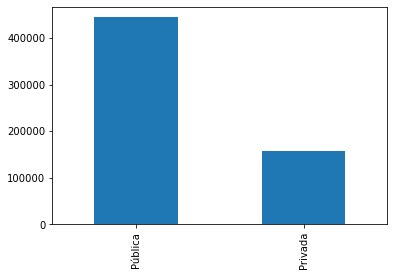

In [5]:
## Quantidade de entradas
df.TP_ESCOLA.value_counts().plot(kind='bar')
plt.show()

In [6]:
## verificação de valores (média, desvio padrão, quartís, máximo e mínimo) para notas da redação
df[['TP_ESCOLA', 'NU_NOTA_REDACAO']].groupby('TP_ESCOLA').describe()

NU_NOTA_REDACAO                                                    \
                    count        mean         std  min    25%    50%    75%   
TP_ESCOLA                                                                     
Privada          158224.0  739.167889  152.249050  0.0  640.0  760.0  860.0   
Pública          444227.0  587.306355  187.779572  0.0  500.0  580.0  700.0   

                   
              max  
TP_ESCOLA          
Privada    1000.0  
Pública    1000.0

In [7]:
## T-Test para comparação de distribuições para notas da redação:
pub = df.loc[df.TP_ESCOLA=='Pública', 'NU_NOTA_REDACAO']
priv = df.loc[df.TP_ESCOLA=='Privada', 'NU_NOTA_REDACAO']

import warnings
warnings.filterwarnings('ignore')

pg.ttest(priv, pub)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,319.530673,340523.1446,two-sided,0.0,"[150.93, 152.79]",0.847764,inf,1.0


O teste nos mostra que a diferença entre as médias é estatisticamente significativa. O poder do teste é 1. Abaixo, vemos os histogramas das duas classes para notas da redação.

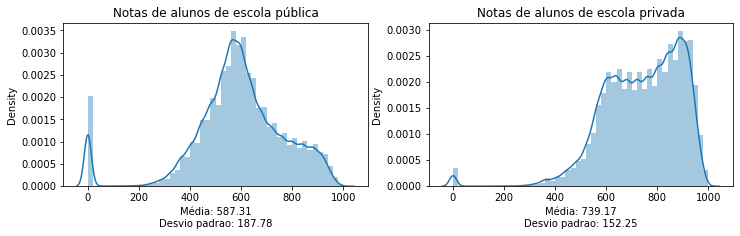

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 3))

p1=sns.distplot(
    pub,
    ax=axes[0],
    axlabel=f'Média: {pub.mean():.2f}\nDesvio padrao: {pub.std():.2f}'
).set_title("Notas de alunos de escola pública")
p2=sns.distplot(
    priv,
    axlabel=f'Média: {priv.mean():.2f}\nDesvio padrao: {priv.std():.2f}'
).set_title("Notas de alunos de escola privada")
plt.show()

Da mesma forma para a nota média:

In [9]:
## verificação de valores (média, desvio padrão, quartís, máximo e mínimo)
df[['TP_ESCOLA', 'NOTA_MEDIA']].groupby('TP_ESCOLA').describe()

NOTA_MEDIA                                                         \
               count        mean        std  min      25%      50%      75%   
TP_ESCOLA                                                                     
Privada     158224.0  570.104080  77.481077  0.0  513.275  571.325  626.175   
Pública     444227.0  497.005666  70.286137  0.0  442.425  487.050  543.100   

                    
               max  
TP_ESCOLA           
Privada    825.575  
Pública    813.050

In [10]:
## T-Test para comparação de distribuições
pub = df.loc[df.TP_ESCOLA=='Pública', 'NOTA_MEDIA']
priv = df.loc[df.TP_ESCOLA=='Privada', 'NOTA_MEDIA']
pg.ttest(x=priv, y=pub, correction=False).round(2)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,345.6,602449,two-sided,0.0,"[72.68, 73.51]",1.01,inf,1.0


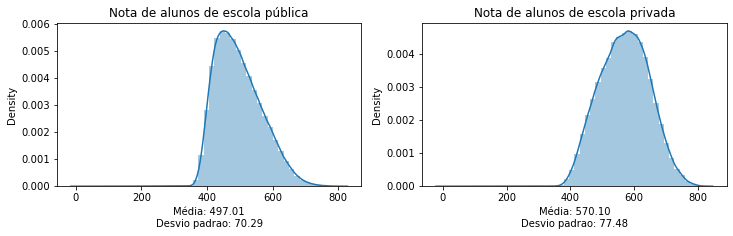

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 3))

p1=sns.distplot(
    pub,
    ax=axes[0],
    axlabel=f'Média: {pub.mean():.2f}\nDesvio padrao: {pub.std():.2f}'
).set_title("Nota de alunos de escola pública")
p2=sns.distplot(
    priv,
    axlabel=f'Média: {priv.mean():.2f}\nDesvio padrao: {priv.std():.2f}'
).set_title("Nota de alunos de escola privada")
plt.show()

### Avaliação Estatística dos dados socioeconômicos

- Vale resaltar que usualmente dados como genero, idade, raça/cor e condições econômicas podem criar interpretações erroneas em modelos de machine learning assumindo interpretações erradas. Para esse estudo vamos iniciar avaliando essas informações de forma crítica levando em conta a desigualdade social presente no Brasil.

In [12]:
## do dicionário de dados

dic_raca_cor = {0:'Não declarado',
                1:'Branca',
                2:'Preta',
                3:'Parda',
                4:'Amarela',
                5:'Indígena',
                6:'Não dispõe da informação'}

dic_estado_civil = {0:'Não informado',
                1:'Solteiro(a)',
                2:'Casado(a)/Mora com companheiro(a)',
                3:'Divorciado(a)/Desquitado(a)/Separado(a)',
                4:'Viúvo(a)'}

## Nacionalidade
dic_nacionalidade = {0:'Não informado',
1:'Brasileiro(a)',
2:'Brasileiro(a) Naturalizado(a)',
3:'Estrangeiro(a)',
4:'Brasileiro(a) Nato(a), nascido(a) no exterior'}

## Faixa etária
dic_idade = {1:'Menor de 17 anos',
2:'17 anos',
3:'18 anos',
4:'19 anos',
5:'20 anos',
6:'21 anos',
7:'22 anos',
8:'23 anos',
9:'24 anos',
10:'25 anos',
11:'Entre 26 e 30 anos',
12:'Entre 31 e 35 anos',
13:'Entre 36 e 40 anos',
14:'Entre 41 e 45 anos',
15:'Entre 46 e 50 anos',
16:'Entre 51 e 55 anos',
17:'Entre 56 e 60 anos',
18:'Entre 61 e 65 anos',
19:'Entre 66 e 70 anos',
20:'Maior de 70 anos'}

## Localização_esc

dic_localizacao = {1:'Urbana',
2:'Rural'}


In [13]:
df2 = df.copy()

df2.TP_COR_RACA = df2.TP_COR_RACA.map(dic_raca_cor)
df2.TP_ESTADO_CIVIL = df2.TP_ESTADO_CIVIL.map(dic_estado_civil)
df2.TP_NACIONALIDADE = df2.TP_NACIONALIDADE.map(dic_nacionalidade)
df2.TP_FAIXA_ETARIA = df2.TP_FAIXA_ETARIA.map(dic_idade)
df2.TP_LOCALIZACAO_ESC = df2.TP_LOCALIZACAO_ESC.map(dic_localizacao)

#### Cor/Raça

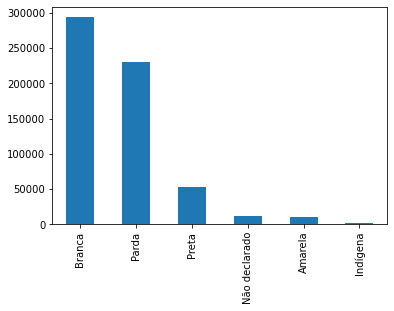

In [14]:
## Quantidade de entradas
df2.TP_COR_RACA.value_counts().plot(kind='bar')
plt.show()

In [15]:
## verificação de valores (média, desvio padrão, quartís, máximo e mínimo) para notas da redação
df2[df2.TP_COR_RACA!='Não declarado'][['TP_COR_RACA', 'NU_NOTA_REDACAO']].groupby('TP_COR_RACA') \
                                                                         .describe()['NU_NOTA_REDACAO'] \
                                                                         .sort_values(by='mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
TP_COR_RACA,,,,,,,,
Branca,293458.0,665.878388,177.402691,0.0,560.0,660.0,800.0,1000.0
Amarela,11183.0,628.233926,189.377214,0.0,520.0,620.0,760.0,980.0
Parda,230001.0,590.087000,197.922294,0.0,500.0,600.0,720.0,1000.0
Preta,53393.0,588.629970,186.431798,0.0,500.0,580.0,700.0,980.0
Indígena,2442.0,511.359541,201.402382,0.0,440.0,540.0,620.0,960.0


In [16]:
## verificação de valores (média, desvio padrão, quartís, máximo e mínimo)
df2[df2.TP_COR_RACA!='Não declarado'][['TP_COR_RACA', 'NOTA_MEDIA']].groupby('TP_COR_RACA') \
                                                                         .describe()['NOTA_MEDIA'] \
                                                                         .sort_values(by='mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
TP_COR_RACA,,,,,,,,
Branca,293458.0,539.679991,79.583163,0.00,477.90000,535.375,597.2000,825.575
Amarela,11183.0,518.449150,83.762995,93.30,451.27500,504.875,577.1375,800.700
Parda,230001.0,493.177696,71.633328,0.00,437.60000,481.350,538.9500,816.725
Preta,53393.0,491.125160,66.504668,91.45,440.00000,481.425,533.8750,795.550
Indígena,2442.0,461.008446,58.209395,251.75,419.24375,449.750,493.7125,737.575


In [17]:
## verificação estatística de diferença

import warnings
warnings.filterwarnings('ignore')

pg.pairwise_ttests(df2[df2.TP_COR_RACA!='Não declarado'], dv='NOTA_MEDIA', between='TP_COR_RACA')

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,hedges
0,TP_COR_RACA,Amarela,Branca,False,True,-26.354211,11963.999681,two-sided,7.756144e-149,4.274e+148,-0.266249
1,TP_COR_RACA,Amarela,Indígena,False,True,40.465991,4927.665172,two-sided,2.253763e-309,inf,0.719874
2,TP_COR_RACA,Amarela,Parda,False,True,31.352321,11990.652684,two-sided,1.870750e-207,9.57e+210,0.349822
3,TP_COR_RACA,Amarela,Preta,False,True,32.422168,14277.527478,two-sided,1.424732e-222,2.573e+224,0.391460
4,TP_COR_RACA,Branca,Indígena,False,True,66.274400,2517.522560,two-sided,0.000000e+00,inf,0.990444
5,TP_COR_RACA,Branca,Parda,False,True,221.962846,513558.438007,two-sided,0.000000e+00,inf,0.610327
6,TP_COR_RACA,Branca,Preta,False,True,150.260194,83802.970349,two-sided,0.000000e+00,inf,0.624792
7,TP_COR_RACA,Indígena,Parda,False,True,-27.092990,2520.122026,two-sided,4.331840e-142,1.981e+157,-0.449884
8,TP_COR_RACA,Indígena,Preta,False,True,-24.836804,2740.712370,two-sided,5.441742e-123,2.529e+131,-0.455178
9,TP_COR_RACA,Parda,Preta,False,True,6.329859,84600.210045,two-sided,2.466094e-10,2.711e+06,0.029033


Podemos verificar que existe uma diferença estatística entre todas as comparações

#### Estado Civíl

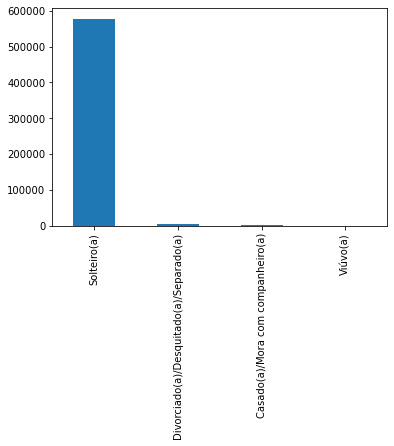

In [18]:
## Quantidade de entradas
df2[df2.TP_ESTADO_CIVIL!='Não informado'].TP_ESTADO_CIVIL.value_counts().plot(kind='bar')
plt.show()

In [19]:
## verificação de valores (média, desvio padrão, quartís, máximo e mínimo) para notas da redação
df2[df2.TP_ESTADO_CIVIL!='Não informado'][['TP_ESTADO_CIVIL', 'NU_NOTA_REDACAO']].groupby('TP_ESTADO_CIVIL') \
                                                                         .describe()['NU_NOTA_REDACAO'] \
                                                                         .sort_values(by='mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
TP_ESTADO_CIVIL,,,,,,,,
Solteiro(a),578425.0,628.818983,190.634390,0.0,540.0,620.0,760.0,1000.0
Divorciado(a)/Desquitado(a)/Separado(a),3421.0,601.449868,194.867483,0.0,520.0,600.0,740.0,980.0
Viúvo(a),112.0,528.392857,206.063725,0.0,440.0,560.0,645.0,920.0
Casado(a)/Mora com companheiro(a),3209.0,520.972266,199.970826,0.0,440.0,540.0,620.0,980.0


In [20]:
## verificação de valores (média, desvio padrão, quartís, máximo e mínimo)
df2[df2.TP_ESTADO_CIVIL!='Não informado'][['TP_ESTADO_CIVIL', 'NOTA_MEDIA']].groupby('TP_ESTADO_CIVIL') \
                                                                         .describe()['NOTA_MEDIA'] \
                                                                         .sort_values(by='mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
TP_ESTADO_CIVIL,,,,,,,,
Solteiro(a),578425.0,516.756738,79.071694,0.000,454.12500,507.2250,571.750,825.575
Divorciado(a)/Desquitado(a)/Separado(a),3421.0,507.849057,79.110137,0.000,446.52500,495.3500,559.825,781.600
Casado(a)/Mora com companheiro(a),3209.0,476.738018,72.530144,90.025,423.72500,458.7000,515.725,790.475
Viúvo(a),112.0,476.203795,74.877051,238.200,430.31875,468.7375,512.775,707.725


In [21]:
## verificação estatística de diferença

import warnings
warnings.filterwarnings('ignore')

pg.pairwise_ttests(df2[df2.TP_ESTADO_CIVIL!='Não informado'], dv='NOTA_MEDIA', between='TP_ESTADO_CIVIL')

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,hedges
0,TP_ESTADO_CIVIL,Casado(a)/Mora com companheiro(a),Divorciado(a)/Desquitado(a)/Separado(a),False,True,-16.704304,6624.549280,two-sided,2.169970e-61,4.748e+57,-0.409328
1,TP_ESTADO_CIVIL,Casado(a)/Mora com companheiro(a),Solteiro(a),False,True,-31.153182,3250.443721,two-sided,1.128033e-186,4.622e+208,-0.506328
2,TP_ESTADO_CIVIL,Casado(a)/Mora com companheiro(a),Viúvo(a),False,True,0.074300,118.384757,two-sided,9.408975e-01,0.107,0.007356
3,TP_ESTADO_CIVIL,Divorciado(a)/Desquitado(a)/Separado(a),Solteiro(a),False,True,-6.566437,3460.533437,two-sided,5.923836e-11,4.348e+07,-0.112653
4,TP_ESTADO_CIVIL,Divorciado(a)/Desquitado(a)/Separado(a),Viúvo(a),False,True,4.393138,119.256139,two-sided,2.435256e-05,1211.496,0.400587
5,TP_ESTADO_CIVIL,Solteiro(a),Viúvo(a),False,True,5.731071,111.047942,two-sided,8.684722e-08,9.154e+05,0.512867


Observando os resultados vemos que não temos diferença significativa entre Viúvos e Casados, porém vale lembrar que a quantidade de amostras disponíveis para todos os grupos que não solteiros é baixa

#### Nacionalidade

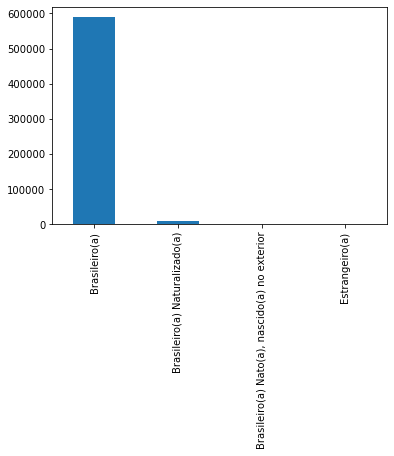

In [22]:
## Quantidade de entradas
df2[df2.TP_NACIONALIDADE!='Não informado'].TP_NACIONALIDADE.value_counts().plot(kind='bar')
plt.show()

In [23]:
## verificação de valores (média, desvio padrão, quartís, máximo e mínimo) para notas da redação
df2[df2.TP_NACIONALIDADE!='Não informado'][['TP_NACIONALIDADE', 'NU_NOTA_REDACAO']].groupby('TP_NACIONALIDADE') \
                                                                         .describe()['NU_NOTA_REDACAO'] \
                                                                         .sort_values(by='mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
TP_NACIONALIDADE,,,,,,,,
"Brasileiro(a) Nato(a), nascido(a) no exterior",1551.0,660.064475,184.315987,0.0,560.0,660.0,800.0,980.0
Brasileiro(a),589747.0,628.160720,191.074270,0.0,520.0,620.0,760.0,1000.0
Brasileiro(a) Naturalizado(a),9841.0,573.106392,186.587110,0.0,480.0,580.0,680.0,980.0
Estrangeiro(a),791.0,563.590392,208.969149,0.0,460.0,580.0,690.0,960.0


In [24]:
## verificação de valores (média, desvio padrão, quartís, máximo e mínimo)
df2[df2.TP_NACIONALIDADE!='Não informado'][['TP_NACIONALIDADE', 'NOTA_MEDIA']].groupby('TP_NACIONALIDADE') \
                                                                         .describe()['NOTA_MEDIA'] \
                                                                         .sort_values(by='mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
TP_NACIONALIDADE,,,,,,,,
"Brasileiro(a) Nato(a), nascido(a) no exterior",1551.0,544.748888,82.494879,322.500,481.6375,543.825,607.050,784.425
Brasileiro(a),589747.0,516.851088,79.175676,0.000,454.0750,507.425,572.025,825.575
Estrangeiro(a),791.0,505.703192,80.470091,221.525,440.7500,495.700,556.750,749.325
Brasileiro(a) Naturalizado(a),9841.0,475.617610,58.784568,204.050,432.3750,466.075,509.200,780.100


In [25]:
## verificação estatística de diferença

import warnings
warnings.filterwarnings('ignore')

pg.pairwise_ttests(df2[df2.TP_NACIONALIDADE!='Não informado'], dv='NOTA_MEDIA', between='TP_NACIONALIDADE')

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,hedges
0,TP_NACIONALIDADE,Brasileiro(a),"Brasileiro(a) Nato(a), nascido(a) no exterior",False,True,-13.302199,1557.519028,two-sided,2.542567e-38,6.115e+36,-0.352313
1,TP_NACIONALIDADE,Brasileiro(a),Brasileiro(a) Naturalizado(a),False,True,68.553631,10444.595429,two-sided,0.000000e+00,inf,0.522712
2,TP_NACIONALIDADE,Brasileiro(a),Estrangeiro(a),False,True,3.893721,792.052882,two-sided,1.070378e-04,75.615,0.140796
3,TP_NACIONALIDADE,"Brasileiro(a) Nato(a), nascido(a) no exterior",Brasileiro(a) Naturalizado(a),False,True,31.756736,1806.193592,two-sided,3.165945e-176,8.741e+207,1.105288
4,TP_NACIONALIDADE,"Brasileiro(a) Nato(a), nascido(a) no exterior",Estrangeiro(a),False,True,11.011182,1625.758168,two-sided,3.015861e-27,1.613e+24,0.477080
5,TP_NACIONALIDADE,Brasileiro(a) Naturalizado(a),Estrangeiro(a),False,True,-10.296559,859.098873,two-sided,1.592723e-23,2.627e+21,-0.495908


Podemos ver que brasileiros nascidos no exterior apresentaram notas maiores, fator que pode estar associado ao nível socioeconômico, novamente com quantidades de amostras desbalanceadas

#### Faixa Etaria

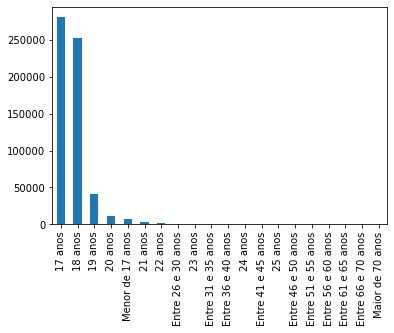

In [26]:
## Quantidade de entradas
df2[df2.TP_FAIXA_ETARIA!='Não informado'].TP_FAIXA_ETARIA.value_counts().plot(kind='bar')
plt.show()

In [27]:
## verificação de valores (média, desvio padrão, quartís, máximo e mínimo) para notas da redação
df2[df2.TP_FAIXA_ETARIA!='Não informado'][['TP_FAIXA_ETARIA', 'NU_NOTA_REDACAO']].groupby('TP_FAIXA_ETARIA') \
                                                                         .describe()['NU_NOTA_REDACAO'] \
                                                                         .sort_values(by='mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
TP_FAIXA_ETARIA,,,,,,,,
Menor de 17 anos,7107.0,676.060222,185.220936,0.0,560.0,680.0,820.0,980.0
17 anos,280141.0,653.322291,180.732275,0.0,560.0,640.0,800.0,1000.0
18 anos,252406.0,621.219305,189.530042,0.0,520.0,620.0,760.0,1000.0
19 anos,41832.0,555.076496,201.232912,0.0,460.0,560.0,660.0,980.0
20 anos,11347.0,513.739314,210.456941,0.0,440.0,540.0,620.0,980.0
Entre 66 e 70 anos,10.0,482.000000,85.608930,360.0,425.0,470.0,555.0,600.0
21 anos,3307.0,469.924403,211.579690,0.0,400.0,520.0,600.0,980.0
22 anos,1328.0,443.162651,215.970352,0.0,380.0,480.0,580.0,940.0
23 anos,716.0,437.486034,204.556060,0.0,360.0,480.0,560.0,920.0


In [28]:
## verificação de valores (média, desvio padrão, quartís, máximo e mínimo)
df2[df2.TP_FAIXA_ETARIA!='Não informado'][['TP_FAIXA_ETARIA', 'NOTA_MEDIA']].groupby('TP_FAIXA_ETARIA') \
                                                                         .describe()['NOTA_MEDIA'] \
                                                                         .sort_values(by='mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
TP_FAIXA_ETARIA,,,,,,,,
17 anos,280141.0,527.370216,78.905516,0.000,465.47500,520.2250,583.27500,822.800
Menor de 17 anos,7107.0,524.292968,76.514658,243.600,464.60000,517.3500,580.21250,789.250
18 anos,252406.0,512.543033,77.617034,0.000,451.55000,502.0000,565.20000,825.575
19 anos,41832.0,487.964510,75.072970,91.450,429.65000,471.5250,535.07500,812.675
20 anos,11347.0,476.407088,73.772690,93.300,420.75000,456.5000,520.13750,771.150
21 anos,3307.0,461.697566,64.932358,237.500,414.22500,443.8250,496.82500,719.425
22 anos,1328.0,455.135410,60.879062,291.925,410.56875,436.5750,489.30000,702.850
23 anos,716.0,450.315119,55.563267,281.450,409.61250,435.4875,480.27500,686.450
24 anos,512.0,445.228027,54.279834,314.975,407.70625,432.6875,475.12500,685.825


In [29]:
## verificação estatística de diferença

import warnings
warnings.filterwarnings('ignore')

pg.pairwise_ttests(df2[df2.TP_FAIXA_ETARIA!='Não informado'], dv='NOTA_MEDIA', between='TP_FAIXA_ETARIA')[pg.pairwise_ttests(df2[df2.TP_FAIXA_ETARIA!='Não informado'], dv='NOTA_MEDIA', between='TP_FAIXA_ETARIA').B=='Menor de 17 anos']

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,hedges
18,TP_FAIXA_ETARIA,17 anos,Menor de 17 anos,False,True,3.345647,7494.467762,two-sided,8.249422e-04,3.64,0.039028
36,TP_FAIXA_ETARIA,18 anos,Menor de 17 anos,False,True,-12.762382,7523.569021,two-sided,6.409650e-37,2.953e+33,-0.151442
53,TP_FAIXA_ETARIA,19 anos,Menor de 17 anos,False,True,-37.106722,9576.961869,two-sided,1.004750e-281,7.368e+292,-0.482545
69,TP_FAIXA_ETARIA,20 anos,Menor de 17 anos,False,True,-41.943905,14674.233259,two-sided,0.000000e+00,inf,-0.639813
84,TP_FAIXA_ETARIA,21 anos,Menor de 17 anos,False,True,-43.208311,7501.370306,two-sided,0.000000e+00,inf,-0.856983
98,TP_FAIXA_ETARIA,22 anos,Menor de 17 anos,False,True,-36.375431,2190.344012,two-sided,4.804513e-227,8.441e+264,-0.931046
111,TP_FAIXA_ETARIA,23 anos,Menor de 17 anos,False,True,-32.644196,1010.582771,two-sided,3.450983e-160,9.549e+214,-0.988342
123,TP_FAIXA_ETARIA,24 anos,Menor de 17 anos,False,True,-30.826806,666.789829,two-sided,2.154769e-130,3.181e+192,-1.050888
134,TP_FAIXA_ETARIA,25 anos,Menor de 17 anos,False,True,-29.575087,429.120534,two-sided,1.310843e-105,4.01e+177,-1.084540
144,TP_FAIXA_ETARIA,Entre 26 e 30 anos,Menor de 17 anos,False,True,-46.497978,2201.178073,two-sided,0.000000e+00,inf,-1.096040


Avaliando unicamente o Grupo menor que 17 anos, vemos que é onde está a maior predominancia de pessoas (considerando que é uma prova usualmente feita no final do ensino médio), outras classes apresentam amostrage muito inferior e o comportamento de redução das notas de redação e da prova se dá de forma equivalente ao aumento de idade até os 24 anos.

#### Localização

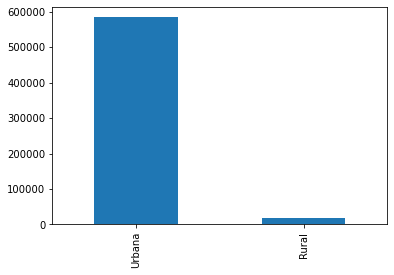

In [30]:
## Quantidade de entradas
df2[df2.TP_LOCALIZACAO_ESC!='Não informado'].TP_LOCALIZACAO_ESC.value_counts().plot(kind='bar')
plt.show()

In [31]:
## verificação de valores (média, desvio padrão, quartís, máximo e mínimo) para notas da redação
df2[df2.TP_LOCALIZACAO_ESC!='Não informado'][['TP_LOCALIZACAO_ESC', 'NU_NOTA_REDACAO']].groupby('TP_LOCALIZACAO_ESC') \
                                                                         .describe()['NU_NOTA_REDACAO'] \
                                                                         .sort_values(by='mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
TP_LOCALIZACAO_ESC,,,,,,,,
Urbana,583986.0,629.166110,190.449453,0.0,540.0,620.0,760.0,1000.0
Rural,18465.0,564.702952,203.683741,0.0,480.0,580.0,680.0,980.0


In [32]:
## verificação de valores (média, desvio padrão, quartís, máximo e mínimo)
df2[df2.TP_LOCALIZACAO_ESC!='Não informado'][['TP_LOCALIZACAO_ESC', 'NOTA_MEDIA']].groupby('TP_LOCALIZACAO_ESC') \
                                                                         .describe()['NOTA_MEDIA'] \
                                                                         .sort_values(by='mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
TP_LOCALIZACAO_ESC,,,,,,,,
Urbana,583986.0,517.158792,79.150837,0.0,454.475,507.65,572.25,825.575
Rural,18465.0,485.999966,70.530337,195.5,430.250,473.15,532.65,769.525


In [33]:
## verificação estatística de diferença

import warnings
warnings.filterwarnings('ignore')

pg.pairwise_ttests(df2[df2.TP_LOCALIZACAO_ESC!='Não informado'], dv='NOTA_MEDIA', between='TP_LOCALIZACAO_ESC')

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,hedges
0,TP_LOCALIZACAO_ESC,Rural,Urbana,False,True,-58.870892,19962.7659,two-sided,0.0,inf,-0.394912


Observando o comportamento de localização (Rural/Urbana), vemos que na área urbana as notas tem uma tendencia a ser maiores, sendo estatísticamente diferentes

#### Estado de realização da prova

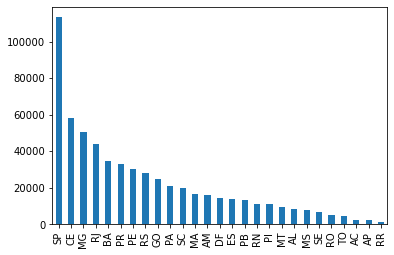

In [34]:
## Quantidade de entradas
df2[df2.SG_UF_PROVA!='Não informado'].SG_UF_PROVA.value_counts().plot(kind='bar')
plt.show()

In [35]:
## verificação de valores (média, desvio padrão, quartís, máximo e mínimo) para notas da redação
df2[df2.SG_UF_PROVA!='Não informado'][['SG_UF_PROVA', 'NU_NOTA_REDACAO']].groupby('SG_UF_PROVA') \
                                                                         .describe()['NU_NOTA_REDACAO'] \
                                                                         .sort_values(by='mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
SG_UF_PROVA,,,,,,,,
MG,50559.0,676.240036,186.140925,0.0,560.0,680.0,840.0,1000.0
RJ,44180.0,663.022635,181.681109,0.0,560.0,660.0,800.0,1000.0
SE,6934.0,660.481684,203.860474,0.0,540.0,660.0,820.0,980.0
RN,11228.0,659.465622,191.285329,0.0,560.0,660.0,820.0,980.0
PI,11185.0,648.826106,205.699869,0.0,520.0,640.0,820.0,980.0
ES,13849.0,647.655426,186.099705,0.0,560.0,640.0,780.0,980.0
PB,13474.0,646.350007,203.789799,0.0,540.0,640.0,800.0,980.0
SP,113213.0,643.751513,162.150563,0.0,560.0,640.0,760.0,1000.0
RS,28069.0,641.375895,173.042181,0.0,540.0,620.0,760.0,980.0


In [36]:
## verificação de valores (média, desvio padrão, quartís, máximo e mínimo)
df2[df2.SG_UF_PROVA!='Não informado'][['SG_UF_PROVA', 'NOTA_MEDIA']].groupby('SG_UF_PROVA') \
                                                                         .describe()['NOTA_MEDIA'] \
                                                                         .sort_values(by='mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
SG_UF_PROVA,,,,,,,,
MG,50559.0,540.696783,81.939292,91.450,475.87500,536.3250,600.70000,821.750
SP,113213.0,539.794734,75.250335,0.000,482.37500,535.3750,592.67500,822.800
SC,20091.0,533.537738,74.750600,208.150,476.17500,529.0500,586.70000,804.000
RJ,44180.0,532.982783,78.459123,198.300,471.30000,526.6000,589.85625,816.050
RS,28069.0,531.491768,75.094146,178.500,473.55000,525.9000,584.72500,810.425
DF,14290.0,529.877357,79.506882,268.150,467.78125,521.4750,584.54375,795.350
PR,32931.0,526.506749,76.392060,190.900,468.35000,519.5750,579.85000,807.575
ES,13849.0,523.772079,77.755318,211.800,462.65000,514.3500,577.65000,812.675
RN,11228.0,520.522571,79.346490,243.175,456.57500,511.4625,575.20625,805.700


In [37]:
## verificação estatística de diferença

import warnings
warnings.filterwarnings('ignore')

pg.pairwise_ttests(df2[df2.SG_UF_PROVA!='Não informado'], dv='NOTA_MEDIA', between='SG_UF_PROVA')[pg.pairwise_ttests(df2[df2.SG_UF_PROVA!='Não informado'], dv='NOTA_MEDIA', between='SG_UF_PROVA')['p-unc']==0]

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,hedges
34,SG_UF_PROVA,AL,MG,False,True,-43.873586,12325.776762,two-sided,0.0,inf,-0.478877
49,SG_UF_PROVA,AL,SP,False,True,-45.326313,9912.405078,two-sided,0.0,inf,-0.503172
52,SG_UF_PROVA,AM,BA,False,True,-56.751530,35325.113596,two-sided,0.0,inf,-0.513629
54,SG_UF_PROVA,AM,DF,False,True,-75.217546,27563.063503,two-sided,0.0,inf,-0.877085
55,SG_UF_PROVA,AM,ES,False,True,-68.233482,27010.743010,two-sided,0.0,inf,-0.803694
...,...,...,...,...,...,...,...,...,...,...,...
304,SG_UF_PROVA,PI,SP,False,True,-49.031086,13177.159214,two-sided,0.0,inf,-0.514764
316,SG_UF_PROVA,RJ,RO,False,True,41.485413,6558.116777,two-sided,0.0,inf,0.545162
332,SG_UF_PROVA,RO,SC,False,True,-39.463223,8265.972200,two-sided,0.0,inf,-0.583741
334,SG_UF_PROVA,RO,SP,False,True,-50.418731,5486.759068,two-sided,0.0,inf,-0.653789


In [38]:

pg.pairwise_ttests(df2[df2.SG_UF_PROVA!='Não informado'], dv='NOTA_MEDIA', between='SG_UF_PROVA')[pg.pairwise_ttests(df2[df2.SG_UF_PROVA!='Não informado'], dv='NOTA_MEDIA', between='SG_UF_PROVA')['p-unc']>=0.05]

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,hedges
12,SG_UF_PROVA,AC,PA,False,True,0.509805,2913.795508,two-sided,0.610227,0.028,0.010557
19,SG_UF_PROVA,AC,RO,False,True,-0.956039,4503.754665,two-sided,0.339104,0.045,-0.024118
25,SG_UF_PROVA,AC,TO,False,True,0.772265,4967.233359,two-sided,0.439994,0.039,0.019353
40,SG_UF_PROVA,AL,PI,False,True,1.051851,19057.325958,two-sided,0.292881,0.028,0.014947
76,SG_UF_PROVA,AP,CE,False,True,0.657065,2399.485106,two-sided,0.511202,0.03,0.013181
80,SG_UF_PROVA,AP,MA,False,True,-0.845300,2881.089917,two-sided,0.398013,0.037,-0.018489
107,SG_UF_PROVA,BA,PB,False,True,-0.892029,23748.001738,two-sided,0.372386,0.017,-0.009192
108,SG_UF_PROVA,BA,PE,False,True,-0.777916,63028.346405,two-sided,0.436622,0.012,-0.006135
183,SG_UF_PROVA,GO,MT,False,True,0.236932,18318.695734,two-sided,0.812712,0.014,0.002780
185,SG_UF_PROVA,GO,PB,False,True,1.561219,27497.561804,two-sided,0.118484,0.041,0.016758


Comparando os estados de realização da prova temos dois grupos um com estados estatísticamente diferentes e um com estados estatisticamente iguais.

## O que é possível prever com esses dados?


Utilizando os metadados do Enem temos algumas opções de predição disponíveis, entre elas podemos verificar a que escola um aluno pertence e também podemos usar dados socioeconômicos para buscar prever a nota média e a nota de redação (lembrando que essas informações devem ser vistas com um olhar cuidadoso podendo acarretar em análises erroneas e preconceituosas), porém para titulo de projeto será avaliado.

In [39]:
df.select_dtypes('object')

,TP_SEXO,TP_ESCOLA,SG_UF_PROVA,Q001,Q002,Q006,Q007
3,M,Pública,CE,B,B,B,A
4,F,Pública,CE,D,E,C,A
33,M,Pública,BA,C,C,B,A
45,F,Pública,ES,H,E,C,A
51,M,Pública,ES,E,F,D,A
...,...,...,...,...,...,...,...
3387928,F,Pública,BA,E,E,F,A
3389073,M,Pública,BA,D,F,B,A
3389248,M,Pública,SP,B,B,C,A
3389288,F,Pública,BA,H,C,A,A


In [40]:
df.TP_SEXO = df.TP_SEXO.replace({'M':0, 'F':1})

In [41]:

X_train, X_test, y_train, y_test = train_test_split(df.drop(['TP_ESCOLA', 'SG_UF_PROVA','Q001','Q002','Q006','Q007'], axis = 1), df.TP_ESCOLA, test_size=0.15, random_state=42)

### Classificando alunos a partir de suas notas

Inicialmente vamos usar um modelo simples de KNN para verificar a possibilidade de predição de tipo de escola

Acurácia: 0.6470321352691218
F1-score médio: 0.6663301322301973
F1-score da classe minoritária: 0.4789008511542042


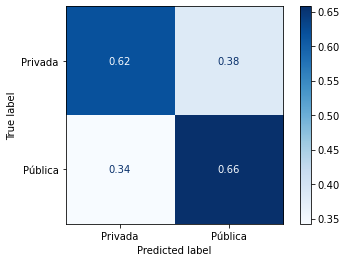

In [42]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=2)

# Definimos uma função para treinamento e exbição dos resultados de um modelo
def pipeline_treino_teste(model):
    # Ajustamos o modelo
    model.fit(X_train, y_train)
    # Submetemos os dados de teste ao classificador 
    y_pred = model.predict(X_test)
    
    # E observamos algumas métricas de desempenho desse modelo: acurácia, F1-score e matriz de confusão
    from sklearn import metrics
    print(f'Acurácia: {metrics.accuracy_score(y_test, y_pred)}')
    print(f'F1-score médio: {metrics.f1_score(y_test, y_pred, average="weighted")}')
    print(f"F1-score da classe minoritária: {metrics.f1_score(y_test, y_pred, pos_label='Privada')}")
    metrics.plot_confusion_matrix(model, X_test, y_test, cmap=plt.cm.Blues, normalize='true')
    
# Agora executamos o pipeline
pipeline_treino_teste(knn)

comparando com um dummy classifier

Acurácia: 0.4987384915014164
F1-score médio: 0.528597411173685
F1-score da classe minoritária: 0.34462802743134935


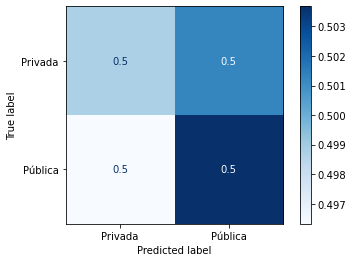

In [43]:

from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="uniform")
pipeline_treino_teste(dummy_clf)

O KNN apresentou resultados superiores a um Dummy Classifier, indicando que é possível prever a escola, mas ainda é possível melhorar:

Usando um modelo um um pouco mais complexo:
Obs.: Optei por usar lightGBM pq é um modelo relativamente simples que usualmente apresenta resultados bons, poderia ter utilizado redes neurais ou modelos stacked para melhorar o resultado, porém optei por esse devido ao tempo.

[20:43:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "class_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Acurácia: 0.7894055417847026
F1-score médio: 0.7759282876132892
F1-score da classe minoritária: 0.5273797402339384


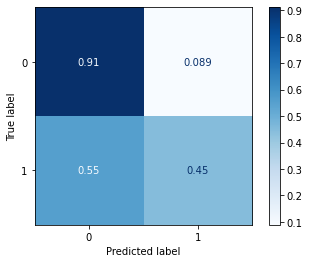

In [44]:
# Definimos uma função para treinamento e exbição dos resultados de um modelo
def pipeline_treino_teste(model):
    # Ajustamos o modelo
    model.fit(X_train, y_train)
    # Submetemos os dados de teste ao classificador 
    y_pred = model.predict(X_test)
    
    # E observamos algumas métricas de desempenho desse modelo: acurácia, F1-score e matriz de confusão
    from sklearn import metrics
    print(f'Acurácia: {metrics.accuracy_score(y_test, y_pred)}')
    print(f'F1-score médio: {metrics.f1_score(y_test, y_pred, average="weighted")}')
    print(f"F1-score da classe minoritária: {metrics.f1_score(y_test, y_pred, pos_label=1)}")
    metrics.plot_confusion_matrix(model, X_test, y_test, cmap=plt.cm.Blues, normalize='true')

y_train = y_train.replace(['Pública', 'Privada'], [0, 1])
y_test = y_test.replace(['Pública', 'Privada'], [0, 1])

model = XGBClassifier(class_weight='balanced')
pipeline_treino_teste(model)

In [45]:
X = df.drop(['TP_ESCOLA', 'SG_UF_PROVA','Q001','Q002','Q006','Q007'], axis = 1)
y = df.TP_ESCOLA

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

In [49]:

model = XGBClassifier(class_weight='balanced')
# 
clf = make_pipeline(model)

[22:15:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "class_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[22:15:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "class_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[22:15:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "class_weight" } might not be used.

  Thi

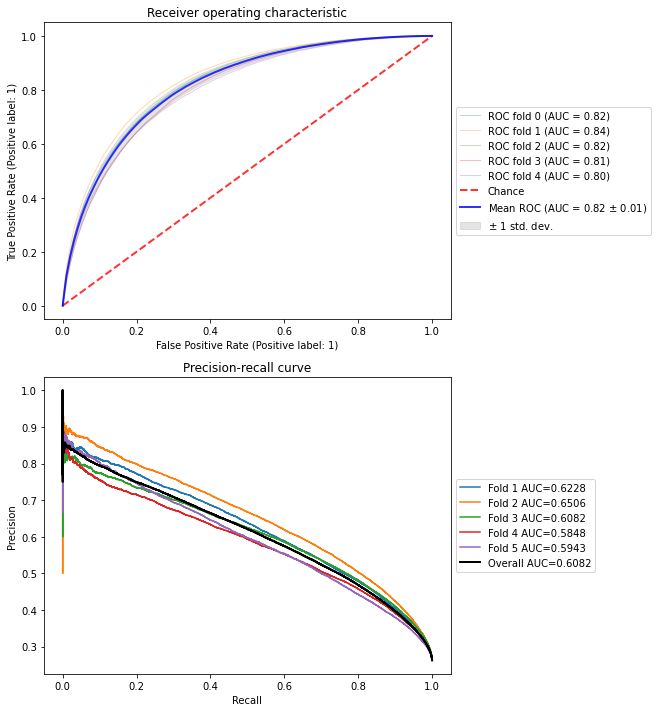

[22:15:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "class_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[22:15:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "class_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[22:15:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "class_weight" } might not be used.

  Thi

In [50]:
importance, results, model = treino_custom.treino(X, y, model=clf, k_fold=True, k=5,  importance=True)

In [53]:
from sklearn.metrics import classification_report
clf.fit(X_train, y_train)
# Submetemos os dados de teste ao classificador 
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['Pública', 'Privada']))

[22:16:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "class_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


              precision    recall  f1-score   support

     Pública       0.82      0.91      0.86     66622
     Privada       0.64      0.45      0.53     23746

    accuracy                           0.79     90368
   macro avg       0.73      0.68      0.70     90368
weighted avg       0.78      0.79      0.78     90368



### Prevendo as notas de provas e redações (considerando dados socioeconômicos***)

In [58]:
ord_enc_features = ['Q001','Q002','Q006', 'Q007']
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()
df[ord_enc_features] = enc.fit_transform(df[ord_enc_features])
df.head()

,TP_FAIXA_ETARIA,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,TP_NACIONALIDADE,TP_ESCOLA,TP_LOCALIZACAO_ESC,SG_UF_PROVA,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,NU_NOTA_REDACAO,Q001,Q002,Q006,Q007,NOTA_MEDIA
3,3,0,1,3,1,Pública,1.0,CE,580.7,678.9,638.9,659.5,780.0,1.0,1.0,1.0,0.0,639.500
4,2,1,1,3,1,Pública,1.0,CE,497.7,532.4,457.6,582.6,780.0,3.0,4.0,2.0,0.0,517.575
33,3,0,1,1,1,Pública,1.0,BA,414.6,410.1,386.7,423.0,700.0,2.0,2.0,1.0,0.0,408.600
45,4,1,1,3,1,Pública,1.0,ES,476.8,608.5,534.2,570.2,640.0,7.0,4.0,2.0,0.0,547.425
51,3,0,1,3,1,Pública,1.0,ES,433.4,622.0,548.3,579.4,680.0,4.0,5.0,3.0,0.0,545.775


In [59]:
df.select_dtypes('object')

,TP_ESCOLA,SG_UF_PROVA
3,Pública,CE
4,Pública,CE
33,Pública,BA
45,Pública,ES
51,Pública,ES
...,...,...
3387928,Pública,BA
3389073,Pública,BA
3389248,Pública,SP
3389288,Pública,BA


In [60]:
onehot_enc_features = [ 'TP_COR_RACA', 'SG_UF_PROVA', 'TP_ESCOLA']
se = pd.get_dummies(df, prefix=onehot_enc_features, columns=onehot_enc_features, drop_first=True)
se.head()

,TP_FAIXA_ETARIA,TP_SEXO,TP_ESTADO_CIVIL,TP_NACIONALIDADE,TP_LOCALIZACAO_ESC,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,NU_NOTA_REDACAO,...,SG_UF_PROVA_RJ,SG_UF_PROVA_RN,SG_UF_PROVA_RO,SG_UF_PROVA_RR,SG_UF_PROVA_RS,SG_UF_PROVA_SC,SG_UF_PROVA_SE,SG_UF_PROVA_SP,SG_UF_PROVA_TO,TP_ESCOLA_Pública
3,3,0,1,1,1.0,580.7,678.9,638.9,659.5,780.0,...,0,0,0,0,0,0,0,0,0,1
4,2,1,1,1,1.0,497.7,532.4,457.6,582.6,780.0,...,0,0,0,0,0,0,0,0,0,1
33,3,0,1,1,1.0,414.6,410.1,386.7,423.0,700.0,...,0,0,0,0,0,0,0,0,0,1
45,4,1,1,1,1.0,476.8,608.5,534.2,570.2,640.0,...,0,0,0,0,0,0,0,0,0,1
51,3,0,1,1,1.0,433.4,622.0,548.3,579.4,680.0,...,0,0,0,0,0,0,0,0,0,1


In [61]:
X_train, X_test, y_train, y_test = train_test_split(
    se.drop(['NOTA_MEDIA', 'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT'], axis = 1), se.NOTA_MEDIA, test_size=0.15, random_state=42
)

In [62]:
from sklearn.linear_model import LinearRegression
from xgboost import XGBRFRegressor
lr = LinearRegression()
lr.fit(X_train, y_train)

from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, lr.predict(X_test))

3120.8607646737123

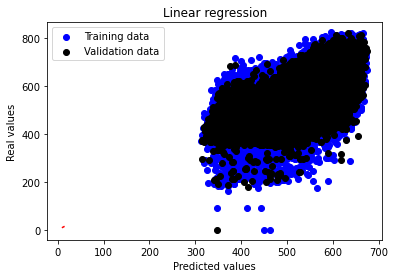

In [63]:

# Plot predictions - Real values
plt.scatter(lr.predict(X_train), y_train, c = "blue",  label = "Training data")
plt.scatter(lr.predict(X_test), y_test, c = "black",  label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

Feature: TP_FAIXA_ETARIA, Score: -0.72437827176338620561
Feature: TP_SEXO, Score: -23.21293430413127012457
Feature: TP_ESTADO_CIVIL, Score: -0.87662840109247397447
Feature: TP_NACIONALIDADE, Score: -3.47790883575949161255
Feature: TP_LOCALIZACAO_ESC, Score: -0.46573052136557346881
Feature: NU_NOTA_REDACAO, Score: 0.19706445575436148943
Feature: Q001, Score: 1.49632003443490924077
Feature: Q002, Score: 1.78113906386784237590
Feature: Q006, Score: 3.78199117227516090622
Feature: Q007, Score: 0.13137728803660531085
Feature: TP_COR_RACA_1, Score: 3.24814305309265227706
Feature: TP_COR_RACA_2, Score: -9.10063670408771585585
Feature: TP_COR_RACA_3, Score: -5.99450005956535481033
Feature: TP_COR_RACA_4, Score: 3.00562296232371295446
Feature: TP_COR_RACA_5, Score: -14.26895727454218310015
Feature: SG_UF_PROVA_AL, Score: 2.60565861715585178615
Feature: SG_UF_PROVA_AM, Score: -3.72381860216395166319
Feature: SG_UF_PROVA_AP, Score: -9.87836186334880395066
Feature: SG_UF_PROVA_BA, Score: 7.5667003

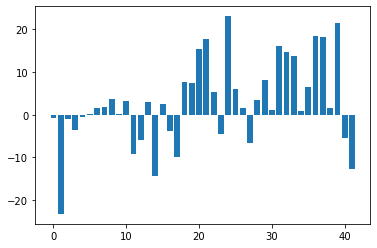

In [64]:
importance = lr.coef_
names = lr.feature_names_in_
# summarize feature importance
for i,v in zip(names,importance):
 print('Feature: %s, Score: %.20f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

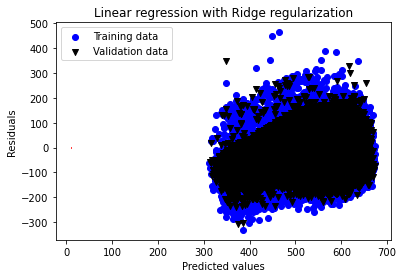

In [65]:

# Plot residuals
plt.scatter(lr.predict(X_train), lr.predict(X_train) - y_train, c = "blue",  label = "Training data")
plt.scatter(lr.predict(X_test), lr.predict(X_test) - y_test, c = "black", marker = "v", label = "Validation data")
plt.title("Linear regression with Ridge regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()


In [66]:
X_train, X_test, y_train, y_test = train_test_split(
    se.drop(['NU_NOTA_REDACAO'], axis = 1), se.NU_NOTA_REDACAO, test_size=0.15, random_state=42
)

lr2 = XGBRFRegressor()
lr2.fit(X_train, y_train)

mean_squared_error(y_test, lr2.predict(X_test))

21336.98329824318

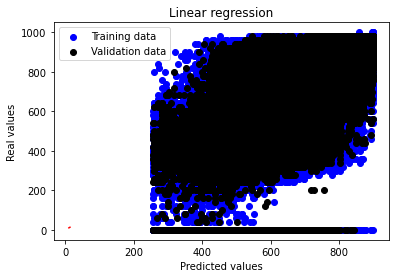

In [67]:

# Plot predictions - Real values
plt.scatter(lr2.predict(X_train), y_train, c = "blue",  label = "Training data")
plt.scatter(lr2.predict(X_test), y_test, c = "black",  label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

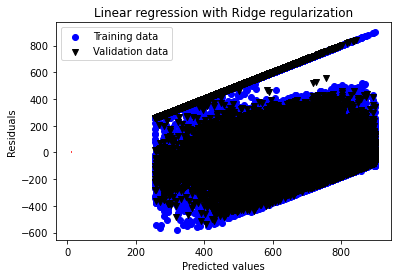

In [68]:

# Plot residuals
plt.scatter(lr2.predict(X_train), lr2.predict(X_train) - y_train, c = "blue",  label = "Training data")
plt.scatter(lr2.predict(X_test), lr2.predict(X_test) - y_test, c = "black", marker = "v", label = "Validation data")
plt.title("Linear regression with Ridge regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()


In [69]:
from xgboost import XGBRegressor
XGboost = XGBRegressor()
XGboost = XGBRegressor(n_estimators=1000, learning_rate=0.05, objective='reg:squarederror', loss='huber')
XGboost.fit(X_train, y_train, early_stopping_rounds=5, 
             eval_set=[(X_test, y_test)], verbose=False)


[22:20:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "loss" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.05, loss='huber', max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, ...)

In [70]:
# make predictions
XGboost_train_pred = XGboost.predict(X_train)
XGboost_test_pred = XGboost.predict(X_test)
print("Mean Squared Error Train: " + str(mean_squared_error(XGboost_train_pred, y_train)))
print("Mean Squared Error Test: " + str(mean_squared_error(XGboost_test_pred, y_test)))


Mean Squared Error Train: 19792.948942504783
Mean Squared Error Test: 20386.534525408646


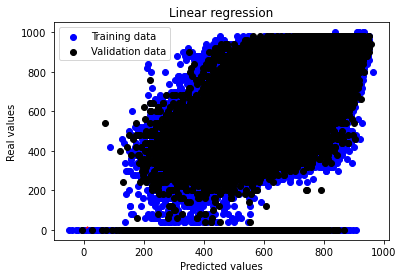

In [71]:
# Plot predictions - Real values
plt.scatter(XGboost_train_pred, y_train, c = "blue",  label = "Training data")
plt.scatter(XGboost_test_pred, y_test, c = "black",  label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()


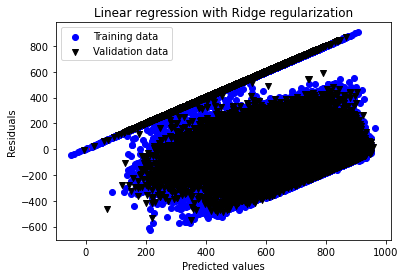

In [72]:
# Plot residuals
plt.scatter(XGboost_train_pred, XGboost_train_pred - y_train, c = "blue",  label = "Training data")
plt.scatter(XGboost_test_pred, XGboost_test_pred - y_test, c = "black", marker = "v", label = "Validation data")
plt.title("Linear regression with Ridge regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

Podemos verificar por esses dados que é possível prever tanto o valor da nota quanto da redação, porém temos variáveis socioeconômicas no modelo que podem levar a interpretações erroneas em relação a grupos de estudantes que realizaram a prova (usualmente sendo recomendado remover de modelos sérios), o objetivo dessa seção era provar que seria possível realizar predições para o tipo de colégio e valores de nota, os dois modelos apresentaram um erro consideravel que poderia ser reduzido utilizando-se de variáveis mais específicas e um maior detalhamento do histórico dos alunos, porém para o objetivo de teste foi possível avalia-los.